In [13]:
from qiskit import *
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.ignis.verification import marginal_counts
from qiskit.quantum_info import random_statevector



In [2]:
%matplotlib inline

In [3]:
# Create random 1-qubit state
psi = random_statevector(2)

# Display it nicely
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
# Show it on a Bloch sphere
plot_bloch_multivector(psi)

init_gate = Initialize(psi)
init_gate.label = "init"

<IPython.core.display.Latex object>

In [4]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers

qr = QuantumRegister(3, name="q")    # Using 3 qubits as q0 -> |psi>(Information of alice) , q1 -> entagled pair from telemon to alice, q2 -> entagled pair from telemon to bob
crz = ClassicalRegister(1, name="crz") # and 2 classical bits
crx = ClassicalRegister(1, name="crx") # in 2 different registers
c0 = ClassicalRegister(1,name="bob")
teleportation_circuit = QuantumCircuit(qr, crz, crx, c0)

#Creating Bell state circuit
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target
    


def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

In [5]:
## STEP 0
# First, let's initialize Alice's q0
teleportation_circuit.append(init_gate, [0])
teleportation_circuit.barrier()


In [6]:

## STEP 1
# In our case, Telamon entangles qubits q1 and q2
# Let's apply this to our circuit:
create_bell_pair(teleportation_circuit, 1, 2)
# And view the circuit so far:
teleportation_circuit.draw()

┌────────────────────────────────────────────┐ ░           
  q_0: ┤ init(-0.13093-0.81648j,-0.076135-0.55716j) ├─░───────────
       └────────────────────────────────────────────┘ ░ ┌───┐     
  q_1: ───────────────────────────────────────────────░─┤ H ├──■──
                                                      ░ └───┘┌─┴─┐
  q_2: ───────────────────────────────────────────────░──────┤ X ├
                                                      ░      └───┘
crz: 1/═══════════════════════════════════════════════════════════
                                                                  
crx: 1/═══════════════════════════════════════════════════════════
                                                                  
bob: 1/═══════════════════════════════════════════════════════════

In [7]:
## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

┌────────────────────────────────────────────┐ ░            ░      ┌───┐
  q_0: ┤ init(-0.13093-0.81648j,-0.076135-0.55716j) ├─░────────────░───■──┤ H ├
       └────────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘
  q_1: ───────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├─────
                                                      ░ └───┘┌─┴─┐ ░ └───┘     
  q_2: ───────────────────────────────────────────────░──────┤ X ├─░───────────
                                                      ░      └───┘ ░           
crz: 1/════════════════════════════════════════════════════════════════════════
                                                                               
crx: 1/════════════════════════════════════════════════════════════════════════
                                                                               
bob: 1/════════════════════════════════════════════════════════════════════════

In [8]:
## STEP 3
#Next, Alice applies a measurement to both qubits that she owns, and stores this result in two classical bits. She then sends these two bits to Bob.

def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)
    
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw()

┌────────────────────────────────────────────┐ ░            ░      ┌───┐»
  q_0: ┤ init(-0.13093-0.81648j,-0.076135-0.55716j) ├─░────────────░───■──┤ H ├»
       └────────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘»
  q_1: ───────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├─────»
                                                      ░ └───┘┌─┴─┐ ░ └───┘     »
  q_2: ───────────────────────────────────────────────░──────┤ X ├─░───────────»
                                                      ░      └───┘ ░           »
crz: 1/════════════════════════════════════════════════════════════════════════»
                                                                               »
crx: 1/════════════════════════════════════════════════════════════════════════»
                                                                               »
bob: 1/════════════════════════════════════════════════════════════════════════»
                                                                               »
«        ░ ┌─┐   
«  q_0: ─░─┤M├───
«        ░ └╥┘┌─┐
«  q_1: ─░──╫─┤M├
«        ░  ║ └╥┘
«  q_2: ─░──╫──╫─
«        ░  ║  ║ 
«crz: 1/════╩══╬═
«           0  ║ 
«crx: 1/═══════╩═
«              0 
«bob: 1/═════════
«

In [9]:
#Step4
#Bob applies the protocoled information
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'
    
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)

teleportation_circuit.draw()


┌────────────────────────────────────────────┐ ░            ░      ┌───┐»
  q_0: ┤ init(-0.13093-0.81648j,-0.076135-0.55716j) ├─░────────────░───■──┤ H ├»
       └────────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘»
  q_1: ───────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├─────»
                                                      ░ └───┘┌─┴─┐ ░ └───┘     »
  q_2: ───────────────────────────────────────────────░──────┤ X ├─░───────────»
                                                      ░      └───┘ ░           »
crz: 1/════════════════════════════════════════════════════════════════════════»
                                                                               »
crx: 1/════════════════════════════════════════════════════════════════════════»
                                                                               »
bob: 1/════════════════════════════════════════════════════════════════════════»
                                                                               »
«        ░ ┌─┐    ░               
«  q_0: ─░─┤M├────░───────────────
«        ░ └╥┘┌─┐ ░               
«  q_1: ─░──╫─┤M├─░───────────────
«        ░  ║ └╥┘ ░  ┌───┐  ┌───┐ 
«  q_2: ─░──╫──╫──░──┤ X ├──┤ Z ├─
«        ░  ║  ║  ░  └─╥─┘  └─╥─┘ 
«           ║  ║       ║   ┌──╨──┐
«crz: 1/════╩══╬═══════╬═══╡ 0x1 ╞
«           0  ║    ┌──╨──┐└─────┘
«crx: 1/═══════╩════╡ 0x1 ╞═══════
«              0    └─────┘       
«bob: 1/══════════════════════════
«

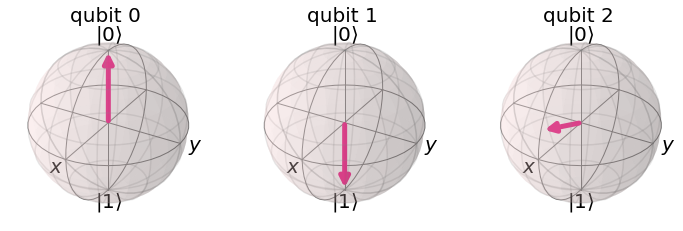

In [10]:


backend = Aer.get_backend('aer_simulator')
teleportation_circuit.save_statevector()
out_vector = backend.run(teleportation_circuit).result().get_statevector()
plot_bloch_multivector(out_vector)

In [11]:
#Measuring the Information that Bob has got
teleportation_circuit.measure(2,c0)
teleportation_circuit.draw()

┌────────────────────────────────────────────┐ ░            ░      ┌───┐»
  q_0: ┤ init(-0.13093-0.81648j,-0.076135-0.55716j) ├─░────────────░───■──┤ H ├»
       └────────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘»
  q_1: ───────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├─────»
                                                      ░ └───┘┌─┴─┐ ░ └───┘     »
  q_2: ───────────────────────────────────────────────░──────┤ X ├─░───────────»
                                                      ░      └───┘ ░           »
crz: 1/════════════════════════════════════════════════════════════════════════»
                                                                               »
crx: 1/════════════════════════════════════════════════════════════════════════»
                                                                               »
bob: 1/════════════════════════════════════════════════════════════════════════»
                                                                               »
«        ░ ┌─┐    ░                ░    
«  q_0: ─░─┤M├────░────────────────░────
«        ░ └╥┘┌─┐ ░                ░    
«  q_1: ─░──╫─┤M├─░────────────────░────
«        ░  ║ └╥┘ ░  ┌───┐  ┌───┐  ░ ┌─┐
«  q_2: ─░──╫──╫──░──┤ X ├──┤ Z ├──░─┤M├
«        ░  ║  ║  ░  └─╥─┘  └─╥─┘  ░ └╥┘
«           ║  ║       ║   ┌──╨──┐    ║ 
«crz: 1/════╩══╬═══════╬═══╡ 0x1 ╞════╬═
«           0  ║    ┌──╨──┐└─────┘    ║ 
«crx: 1/═══════╩════╡ 0x1 ╞═══════════╬═
«              0    └─────┘           ║ 
«bob: 1/══════════════════════════════╩═
«                                     0

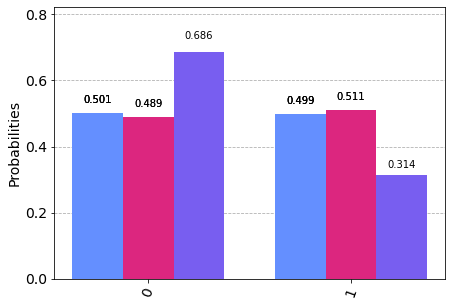

In [12]:

counts = backend.run(teleportation_circuit).result().get_counts()
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)]
plot_histogram(qubit_counts)